<a href="https://colab.research.google.com/github/jsalbert/biotorch/blob/release/benchmark_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

--2024-04-01 08:58:12--  https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Resolving aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud)... 169.63.118.98
Connecting to aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud (aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud)|169.63.118.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379097055 (362M) [application/octet-stream]
Saving to: ‘aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.1’

aihwkit-0.8.0+cuda1 100%[===================>] 361.53M  30.4MB/s    in 9.6s    

2024-04-01 08:58:22 (37.6 MB/s) - ‘aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.1’ saved [379097055/379097055]

Processing ./aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2

In [ ]:

!pip install biotorch --upgrade


# setting the seed

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # pour les opérations multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Exemple d'utilisation
set_seed(42)


# Imports

In [ ]:
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import biotorch
from biotorch.layers.utils import convert_layer

# from biotorch.benchmark.run import Benchmark
# from biotorch.module.biomodule import BioModule


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
# Updated normalization values for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize using mean and std specific to CIFAR-10 across RGB channels
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# Load the CIFAR-10 dataset
dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 170498071/170498071 [00:05<00:00, 29339052.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# BRSF

In [ ]:
from biotorch.module.biomodule import BioModule

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x, targets=None, loss_function=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet for CIFAR-10
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x,targets=None, loss_function=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])

brsf_model = ResNet56().to(device)
optimizer = optim.SGD(brsf_model.parameters(), lr=0.1)
brsf_model = BioModule(module=brsf_model, mode='brsf')
brsf_model.to(device)
print(device)
epochs = 100

for epoch in range(epochs):
    brsf_model.train()  # Make sure the model is in training mode
    correct = 0
    total = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = brsf_model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        total_loss += loss.item()
    if epoch == 49:
      optimizer = optim.SGD(brsf_model.parameters(), lr = 0.01)
    if epoch == 74:
      optimizer = optim.SGD(brsf_model.parameters(), lr = 0.001)


    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total

    print(f'Epoch: {epoch}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.2f}%')

    brsf_model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = brsf_model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            test_total += target.size(0)

    test_accuracy = 100. * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%\n')

Module has been converted to brsf mode:

The layer configuration was:  {'type': 'brsf', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 57 <class 'torch.nn.modules.conv.Conv2d'> layers were converted successfully.
- All the 1 <class 'torch.nn.modules.linear.Linear'> layers were converted successfully.
cuda
Epoch: 0, Loss: 1.949724, Accuracy: 28.83%
Test Accuracy: 24.40%

Epoch: 1, Loss: 1.654911, Accuracy: 38.84%
Test Accuracy: 22.60%

Epoch: 2, Loss: 1.548800, Accuracy: 43.29%
Test Accuracy: 32.42%

Epoch: 3, Loss: 1.468767, Accuracy: 46.31%
Test Accuracy: 41.70%

Epoch: 4, Loss: 1.406948, Accuracy: 48.73%
Test Accuracy: 39.40%

Epoch: 5, Loss: 1.363233, Accuracy: 50.66%
Test Accuracy: 34.14%

Epoch: 6, Loss: 1.314078, Accuracy: 52.65%
Test Accuracy: 43.80%

Epoch: 7, Loss: 1.276318, Accuracy: 53.97%
Test Accuracy: 37.80%

Epoch: 8, Loss: 1.242456, Accuracy: 55.26%
Test Accuracy: 46.96%

Epoch: 9, Loss: 1.200648, Accuracy: 57.07%
Test Accur

# analog

In [ ]:
import math
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD
from torch.optim import SGD
from aihwkit.simulator.configs import FloatingPointRPUConfig, SingleRPUConfig, UnitCellRPUConfig, InferenceRPUConfig, DigitalRankUpdateRPUConfig
from aihwkit.simulator.configs.devices import *
from aihwkit.simulator.configs.utils import PulseType
# from aihwkit.simulator.rpu_base import cuda
from aihwkit.inference import BaseNoiseModel, PCMLikeNoiseModel, StateIndependentNoiseModel
from aihwkit.simulator.configs.utils import WeightClipType,WeightModifierType, IOParameters
from aihwkit.inference.compensation.drift import GlobalDriftCompensation

def create_rpu_config_new():
    rpu_config = InferenceRPUConfig()
    rpu_config.clip.type = WeightClipType.FIXED_VALUE
    rpu_config.clip.fixed_value = 1.0
    rpu_config.modifier.type = WeightModifierType.MULT_NORMAL
    rpu_config.modifier.std_dev = 0.05
    rpu_config.modifier.rel_to_actual_wmax = True
    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.weight_scaling_omega = 1.0
    rpu_config.mapping.weight_scaling_columnwise = True
    rpu_config.mapping.learn_out_scaling = True
    rpu_config.mapping.out_scaling_columnwise = True
    rpu_config.mapping.max_input_size = 256
    rpu_config.mapping.max_output_size = 255
    #rpu_config.input_range.enable = False
    rpu_config.forward = IOParameters()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.inp_res = 1/ (2**8 - 2) # 8-bit resolution.
    rpu_config.forward.out_res = 1/ (2**8 - 2) # 8-bit resolution.
    #rpu_config.forward.bound_management = BoundManagementType.NONE
    #rpu_config.forward.noise_management = NoiseManagementType.NONE
    # Compute how many HIGH inputs would saturate the ADC when all
    # devices are set to Gmax.
    rpu_config.forward.out_bound = math.ceil(110 / (0.2 * 180))
    rpu_config.forward.out_noise = 0.1
    rpu_config.noise_model = PCMLikeNoiseModel(g_max=180)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config

In [ ]:
rpu_config = create_rpu_config_new()
analog_model = convert_to_analog(fa_model, rpu_config)
analog_optimizer = AnalogSGD(analog_model.parameters(), lr=0.001)


### Analog model training

In [ ]:
print(device)
epochs = 50

for epoch in range(epochs):
    analog_model.train()  # Make sure the model is in training mode
    correct = 0
    total = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        analog_optimizer.zero_grad()
        output = analog_model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        analog_optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        total_loss += loss.item()
    if epoch == 49:
      optimizer = AnalogSGD(analog_model.parameters(), lr = 0.01)
    if epoch == 74:
      optimizer = AnalogSGD(analog_model.parameters(), lr = 0.001)
    analog_model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = analog_model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            test_total += target.size(0)

    test_accuracy = 100. * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%\n')

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total

    print(f'Epoch: {epoch}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.2f}%')




cuda
Test Accuracy: 46.80%

Epoch: 0, Loss: 1.350842, Accuracy: 52.19%
Test Accuracy: 48.68%

Epoch: 1, Loss: 1.355393, Accuracy: 52.02%
Test Accuracy: 49.30%

Epoch: 2, Loss: 1.342498, Accuracy: 52.58%
Test Accuracy: 48.22%

Epoch: 3, Loss: 1.345804, Accuracy: 52.24%
Test Accuracy: 49.48%

Epoch: 4, Loss: 1.342082, Accuracy: 52.44%
Test Accuracy: 47.18%

Epoch: 5, Loss: 1.333787, Accuracy: 52.76%
Test Accuracy: 49.88%

Epoch: 6, Loss: 1.334046, Accuracy: 53.06%
Test Accuracy: 49.64%

Epoch: 7, Loss: 1.333417, Accuracy: 52.74%
Test Accuracy: 48.56%

Epoch: 8, Loss: 1.328034, Accuracy: 53.13%
Test Accuracy: 49.12%

Epoch: 9, Loss: 1.324486, Accuracy: 53.04%
Test Accuracy: 49.88%

Epoch: 10, Loss: 1.326068, Accuracy: 53.04%
Test Accuracy: 49.20%

Epoch: 11, Loss: 1.322651, Accuracy: 53.15%
Test Accuracy: 47.38%

Epoch: 12, Loss: 1.317934, Accuracy: 53.38%
Test Accuracy: 45.94%

Epoch: 13, Loss: 1.309221, Accuracy: 53.84%
Test Accuracy: 49.28%

Epoch: 14, Loss: 1.306808, Accuracy: 53.95%


In [ ]:
analog_model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
with torch.no_grad():  # Disable gradient calculation
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = analog_model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        test_correct += pred.eq(target.view_as(pred)).sum().item()
        test_total += target.size(0)

test_accuracy = 100. * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%\n')

In [ ]:
# measure the drift


def test_inference(model, criterion, test_data, device):
    t_inference_list = [1, 60, 3600, 3600*24, 3600*24*7]
    for t_inference in t_inference_list:
        model.drift_analog_weights(t_inference)

        total_loss = 0
        predicted_ok = 0
        total_images = 0

        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred.data, 1)
            total_images += labels.size(0)
            predicted_ok += (predicted == labels).sum().item()

        accuracy = predicted_ok / total_images * 100
        error = 100 - accuracy  # Direct calculation of error

        print(f'After {t_inference} seconds of inference time:')
        print(f'Loss: {total_loss/total_images:.4f}, Accuracy: {accuracy:.2f}%, Error: {error:.2f}%\n')

test_inference(analog_model, F.cross_entropy, val_loader)

In [ ]:
import torchattacks
from tqdm.auto import tqdm, trange
from torchvision import transforms
from torchattacks.attack import Attack
from torchattacks.attacks._differential_evolution import differential_evolution
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch
import numpy as np


In [ ]:
class OnePixel(Attack):
    r"""
    Attack in the paper 'One pixel attack for fooling deep neural networks'
    [https://arxiv.org/abs/1710.08864]

    Modified from "https://github.com/DebangLi/one-pixel-attack-pytorch/" and
    "https://github.com/sarathknv/adversarial-examples-pytorch/blob/master/one_pixel_attack/"

    Distance Measure : L0

    Arguments:
        model (nn.Module): model to attack.
        pixels (int): number of pixels to change (Default: 1)
        steps (int): number of steps. (Default: 10)
        popsize (int): population size, i.e. the number of candidate agents or "parents" in differential evolution (Default: 10)
        inf_batch (int): maximum batch size during inference (Default: 128)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.OnePixel(model, pixels=1, steps=10, popsize=10, inf_batch=128)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, pixels=1, steps=10, popsize=10, inf_batch=128):
        super().__init__("OnePixel", model)
        self.pixels = pixels
        self.steps = steps
        self.popsize = popsize
        self.inf_batch = inf_batch
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        batch_size, channel, height, width = images.shape

        bounds = [(0, height), (0, width)] + [(0, 1)] * channel
        bounds = bounds * self.pixels

        popmul = max(1, int(self.popsize / len(bounds)))

        adv_images = []
        for idx in range(batch_size):
            image, label = images[idx : idx + 1], labels[idx : idx + 1]

            if self.targeted:
                target_label = target_labels[idx : idx + 1]

                def func(delta):
                    return self._loss(image, target_label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, target_label, delta)

            else:

                def func(delta):
                    return self._loss(image, label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, label, delta)

            delta = differential_evolution(
                func=func,
                bounds=bounds,
                callback=callback,
                maxiter=self.steps,
                popsize=popmul,
                init="random",
                recombination=1,
                atol=-1,
                polish=False,
            ).x
            delta = np.split(delta, len(delta) / len(bounds))
            adv_image = self._perturb(image, delta)
            adv_images.append(adv_image)

        adv_images = torch.cat(adv_images)
        return adv_images



    def _loss(self, image, label, delta):
        adv_images = self._perturb(image, delta)  # Mutiple delta
        prob = self._get_prob(adv_images)[:, label]
        if self.targeted:
            return 1 - prob  # If targeted, increase prob
        else:
            return prob  # If non-targeted, decrease prob

    def _attack_success(self, image, label, delta):
        adv_image = self._perturb(image, delta)  # Single delta
        prob = self._get_prob(adv_image)
        pre = np.argmax(prob)
        if self.targeted and (pre == label):
            return True
        elif (not self.targeted) and (pre != label):
            return True
        return False

    def _get_prob(self, images):
        with torch.no_grad():
            batches = torch.split(images, self.inf_batch)
            outs = []
            for batch in batches:
                out = self.get_logits(batch)
                outs.append(out)
        outs = torch.cat(outs)
        prob = F.softmax(outs, dim=1)
        return prob.detach().cpu().numpy()

    def _perturb(self, image, delta):
        delta = np.array(delta)
        if len(delta.shape) < 2:
            delta = np.array([delta])
        num_delta = len(delta)
        adv_image = image.clone().detach().to(self.device)
        adv_images = torch.cat([adv_image] * num_delta, dim=0)
        for idx in range(num_delta):
            pixel_info = delta[idx].reshape(self.pixels, -1)
            for pixel in pixel_info:
                pos_x, pos_y = pixel[:2]
                channel_v = pixel[2:]
                for channel, v in enumerate(channel_v):
                    adv_images[idx, channel, int(pos_x), int(pos_y)] = v
        return adv_images




def apply_attack_on_limited_dataset(model, dataloader, attack, device, verbose=True, n=1):
    robust_accuracy = []
    c_a = []
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        c_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())

    clean_accuracy = np.mean(c_a)
    print('Clean accuracy: ', clean_accuracy)

    r_a = []
    if verbose:
        t = trange(len(dataloader))
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        outputs = model(adv_images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        r_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())
        if verbose:
            t.update(1)

    robust_acc = np.mean(r_a)
    if verbose:
        print('Robust accuracy: ', robust_acc)
    robust_accuracy.append(robust_acc)

    return clean_accuracy, robust_accuracy





In [ ]:
analog_model = 0

In [ ]:
clean_accuracy_list, robust_accuracy_list = [], []
for n_pixel in range(1,6):
    attack = OnePixel(brsf_model, pixels=n_pixel, steps=10, popsize=10, inf_batch=128)
    clean_accuracy, robust_accuracy = apply_attack_on_limited_dataset(brsf_model, val_loader, attack, device, verbose=True, n=5)
    clean_accuracy_list.append(clean_accuracy)
    robust_accuracy_list.append(robust_accuracy)

Clean accuracy:  0.575


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.46875
Clean accuracy:  0.534375


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.390625
Clean accuracy:  0.546875


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.396875
Clean accuracy:  0.571875


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.340625
Clean accuracy:  0.571875


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.303125


In [ ]:
clean_accuracy_analog_list, robust_accuracy_analog_list = [], []
for n_pixel in range(1,6):
    attack_analog = OnePixel(analog_model, pixels=n_pixel)
    clean_accuracy_analog, robust_accuracy_analog = apply_attack_on_limited_dataset(analog_model, val_loader, attack_analog, device, verbose=True, n=5)
    clean_accuracy_analog_list.append(clean_accuracy_analog)
    robust_accuracy_analog_list.append(robust_accuracy_analog)

Clean accuracy:  0.5625


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.45625
Clean accuracy:  0.55625


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.40625
Clean accuracy:  0.484375


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.375
Clean accuracy:  0.546875


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.334375
Clean accuracy:  0.515625


  0%|          | 0/79 [00:00<?, ?it/s]

Robust accuracy:  0.353125


In [ ]:
clean_accuracy_bp_list, robust_accuracy_bp_list = [], []
for n_pixel in range(1,6):
    attack_bp = OnePixel(amodel, pixels=n_pixel)
    clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_limited_dataset(amodel, val_loader, attack_bp, device, verbose=True, n=5)
    clean_accuracy_bp_list.append(clean_accuracy_bp)
    robust_accuracy_bp_list.append(robust_accuracy_bp)

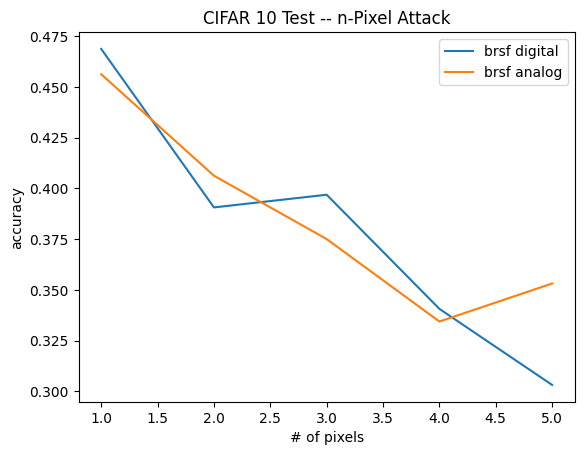

In [ ]:
plot_accuracy(list(range(1,6)),
              [
                  robust_accuracy_list,
                  robust_accuracy_analog_list,
                            ],
              [ 'brsf digital', 'brsf analog'],
              'CIFAR 10 Test -- n-Pixel Attack',
             '# of pixels')

In [ ]:
# measure the drift


def test_inference(model, criterion, test_data):

    from numpy import logspace, log10

    total_loss = 0
    predicted_ok = 0
    total_images = 0
    accuracy_pre = 0
    error_pre = 0

    # Create the t_inference_list using inference_time.
    # Generate the 9 values between 0 and the inference time using log10
    n_times = 9
    t_inference_list = [1,60,3600,3600*24,3600*24*7]

    # Simulation of inference pass at different times after training.
    for t_inference in t_inference_list:
        model.drift_analog_weights(t_inference)

        time_since = t_inference
        accuracy_post = 0
        error_post = 0
        predicted_ok = 0
        total_images = 0

        for images, labels in test_data:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(pred.data, 1)
            total_images += labels.size(0)
            predicted_ok += (predicted == labels).sum().item()
            accuracy_post = predicted_ok/total_images*100
            error_post = (1-predicted_ok/total_images)*100

        print(f'Error after inference: {error_post:.2f}\t'
              f'Accuracy after inference: {accuracy_post:.2f}%\t'
              f'Drift t={time_since: .2e}\t')
test_inference(analog_model, F.cross_entropy, val_loader)

Error after inference: 44.82	Accuracy after inference: 55.18%	Drift t= 1.00e+00	


## FGSM attack

In [ ]:
class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 0.007)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.FGSM(model, eps=0.007)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, eps=0.35, mode='bp'):
        super().__init__("FGSM", model)
        self.eps = eps
        self._supported_mode = ['default', 'targeted']
        self.mode=mode

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        loss_function = nn.CrossEntropyLoss()

        images.requires_grad = True

        outputs = self.model(images)

        # Calculate loss
        cost = loss_function(outputs, labels)

        if self.mode == 'DFA':
            # Zero gradients
            self.model.zero_grad()
            loss_gradient = torch.autograd.grad(cost, outputs, retain_graph=True)[0]
            # Broadcast gradient of the loss to every layer
            for layer in self.model[1].module.modules():
                layer.loss_gradient = loss_gradient

            cost.backward()
            grad = images.grad

        else:
            # Update adversarial images
            grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
        # save the gradient w.r.t. the input for further inspection
        self.grad = grad
        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

Clean accuracy:  0.568038
Clean accuracy:  0.5844541


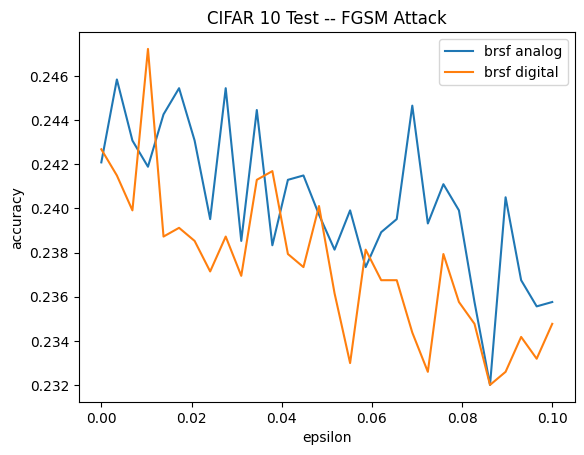

In [ ]:
epsilons = np.linspace(0., 0.1, num=30)

analog_attack = FGSM(analog_model, mode="brsf")
analog_model = analog_model.to(device)
clean_accuracy_analog, robust_accuracy_analog = apply_attack_on_dataset(analog_model, val_loader,
                                                                analog_attack, epsilons, device, verbose=False)

attack_bp = FGSM(brsf_model, mode="brsf")
brsf_model = brsf_model.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(brsf_model, val_loader,
                                                                attack_bp, epsilons, device, verbose=False)
plot_accuracy(epsilons,
              [
                  robust_accuracy_analog,
                  robust_accuracy_bp,
                            ],
              ['brsf analog', 'brsf digital'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

In [ ]:
print(robust_accuracy_analog)

## PGD attack

In [ ]:
class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 0.3)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 40)
        random_start (bool): using random initialization of delta. (Default: True)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=40, random_start=True)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, eps=0.35, mode='bp',
                 alpha=2/255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self._supported_mode = ['default', 'targeted']
        self.mode = mode

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.model(adv_images)

            # Calculate loss
            cost = loss(outputs, labels)

            if self.mode == 'DFA':
                # Zero gradients
                self.model.zero_grad()
                loss_gradient = torch.autograd.grad(cost, outputs, retain_graph=True)[0]
                # Broadcast gradient of the loss to every layer
                for layer in self.model[1].module.modules():
                    layer.loss_gradient = loss_gradient

                cost.backward()
                grad = adv_images.grad

            else:
                # Update adversarial images
                grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            # save the gradient w.r.t. the input for further inspection
            self.grad = grad
            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [ ]:

analog_attack = PGD(analog_model, mode="brsf")
analog_model = analog_model.to(device)
clean_accuracy_analog, robust_accuracy_analog = apply_attack_on_dataset(analog_model, val_loader,
                                                                analog_attack, epsilons, device, verbose=False)

attack_bp = PGD(brsf_model, mode ="brsf")
brsf_model = brsf_model.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(brsf_model, val_loader,
                                                                attack_bp, epsilons, device, verbose=False)
plot_accuracy(epsilons,
              [
                  robust_accuracy_analog,
                  robust_accuracy_bp,
                            ],
              ['brsf analog' ,'brsf digital'],
              'CIFAR 10 Test -- PGD Attack',
             'epsilon')

In [ ]:
# Run the PGD attack on the test set
images, labels = iter(val_loader).next()
# mixed-analog
adv_images_analog, success_analog, accuracy_clean_analog, accuracy_robust_analog = apply_attack_on_batch(analog_model, images, labels, analog_attack, device)
plot_images_analog = images[success_analog]
plot_images_adv_analog = adv_images_analog[success_analog]
# bp
adv_images_bp, success_bp, accuracy_clean_bp, accuracy_robust_bp = apply_attack_on_batch(brsf_model, images, labels, attack_bp, device)
plot_images_bp = images[success_bp]
plot_images_adv_bp = adv_images_bp[success_bp]


# TPGD attack

In [ ]:
class TPGD(Attack):
    r"""
    PGD based on KL-Divergence loss in the paper 'Theoretically Principled Trade-off between Robustness and Accuracy'
    [https://arxiv.org/abs/1901.08573]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): strength of the attack or maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 7)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=7)
        >>> adv_images = attack(images)
    """
    def __init__(self, model, mode='bp', eps=8/255, alpha=2/255, steps=7):
        super().__init__("TPGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self._supported_mode = ['default']
        self.mode = mode

    def forward(self, images, labels=None):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        logit_ori = self.model(images).detach()
        labels = F.softmax(logit_ori, dim=1)

        adv_images = images + 0.001*torch.randn_like(images)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        loss = nn.KLDivLoss(reduction='sum')

        for _ in range(self.steps):
            adv_images.requires_grad = True
            logit_adv = self.model(adv_images)
            outputs = F.log_softmax(logit_adv, dim=1)
            # Calculate loss
            cost = loss(outputs, labels)

            if self.mode == 'DFA':
                # Zero gradients
                self.model.zero_grad()
                loss_gradient = torch.autograd.grad(cost, outputs, retain_graph=True)[0]
                # Broadcast gradient of the loss to every layer
                for layer in self.model[1].module.modules():
                    layer.loss_gradient = loss_gradient

                cost.backward()
                grad = adv_images.grad

            else:
                # Update adversarial images
                grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [ ]:
epsilons = np.linspace(0., 0.1, num=30)
attack_sign_usf = TPGD(brsf_model)
usf_model = usf_model.to(device)
clean_accuracy_sign_usf, robust_accuracy_sign_usf = apply_attack_on_dataset(brsf_model, val_loader,
                                                                attack_sign_usf, epsilons, device, verbose=False)
print(clean_accuracy_sign_usf)
print(robust_accuracy_sign_usf)


In [ ]:
attack_analog = TPGD(analog_model)
analog_model = analog_model.to(device)
clean_accuracy_analog, robust_accuracy_analog = apply_attack_on_dataset(analog_model, val_loader,
                                                                attack_analog, epsilons, device, verbose=False)
print(clean_accuracy_analog)
print(robust_accuracy_analog)


In [ ]:
plot_accuracy(epsilons,
              [
                  robust_accuracy_analog,
                  robust_accuracy_sign_usf,
                            ],
              ['analog brsf', 'digital brsf'],
              'CIFAR 10 Test -- TPGD Attack',
             'epsilon')

# square attack

In [ ]:
class Square(Attack):
    r"""
    Square Attack in the paper 'Square Attack: a query-efficient black-box adversarial attack via random search'
    [https://arxiv.org/abs/1912.00049]
    [https://github.com/fra31/auto-attack]
    Distance Measure : Linf, L2
    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: None)
        n_queries (int): max number of queries (each restart). (Default: 5000)
        n_restarts (int): number of random restarts. (Default: 1)
        p_init (float): parameter to control size of squares. (Default: 0.8)
        loss (str): loss function optimized ['margin', 'ce'] (Default: 'margin')
        resc_schedule (bool): adapt schedule of p to n_queries (Default: True)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)
        targeted (bool): targeted. (Default: False)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.Square(model, model, norm='Linf', n_queries=5000, n_restarts=1, eps=None, p_init=.8, seed=0, verbose=False, targeted=False, loss='margin', resc_schedule=True)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, norm='Linf', eps=None, n_queries=50, n_restarts=1,
                 p_init=.8, loss='margin', resc_schedule=True,
                 seed=0, verbose=False):
        super().__init__("Square", model)
        self.norm = norm
        self.n_queries = n_queries
        self.eps = eps
        self.p_init = p_init
        self.n_restarts = n_restarts
        self.seed = seed
        self.verbose = verbose
        self.loss = loss
        self.rescale_schedule = resc_schedule
        self._supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def margin_and_loss(self, x, y):
        """
        :param y:        correct labels if untargeted else target labels
        """

        logits = self.model(x)
        xent = F.cross_entropy(logits, y, reduction='none')
        u = torch.arange(x.shape[0])
        y_corr = logits[u, y].clone()
        logits[u, y] = -float('inf')
        y_others = logits.max(dim=-1)[0]

        if not self._targeted:
            if self.loss == 'ce':
                return y_corr - y_others, -1. * xent
            elif self.loss == 'margin':
                return y_corr - y_others, y_corr - y_others
        else:
            if self.loss == 'ce':
                return y_others - y_corr, xent
            elif self.loss == 'margin':
                return y_others - y_corr, y_others - y_corr

    def init_hyperparam(self, x):
        assert self.norm in ['Linf', 'L2']
        assert not self.eps is None
        assert self.loss in ['ce', 'margin']

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)
        if self.seed is None:
            self.seed = time.time()

    def check_shape(self, x):
        return x if len(x.shape) == (self.ndims + 1) else x.unsqueeze(0)

    def random_choice(self, shape):
        t = 2 * torch.rand(shape).to(self.device) - 1
        return torch.sign(t)

    def random_int(self, low=0, high=1, shape=[1]):
        t = low + (high - low) * torch.rand(shape).to(self.device)
        return t.long()

    def normalize(self, x):
        if self.norm == 'Linf':
            t = x.abs().view(x.shape[0], -1).max(1)[0]
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

        elif self.norm == 'L2':
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    def lp_norm(self, x):
        if self.norm == 'L2':
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return t.view(-1, *([1] * self.ndims))

    def eta_rectangles(self, x, y):
        delta = torch.zeros([x, y]).to(self.device)
        x_c, y_c = x // 2 + 1, y // 2 + 1

        counter2 = [x_c - 1, y_c - 1]
        for counter in range(0, max(x_c, y_c)):
          delta[max(counter2[0], 0):min(counter2[0] + (2*counter + 1), x),
              max(0, counter2[1]):min(counter2[1] + (2*counter + 1), y)
              ] += 1.0/(torch.Tensor([counter + 1]).view(1, 1).to(
              self.device) ** 2)
          counter2[0] -= 1
          counter2[1] -= 1

        delta /= (delta ** 2).sum(dim=(0,1), keepdim=True).sqrt()

        return delta

    def eta(self, s):
        delta = torch.zeros([s, s]).to(self.device)
        delta[:s // 2] = self.eta_rectangles(s // 2, s)
        delta[s // 2:] = -1. * self.eta_rectangles(s - s // 2, s)
        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()
        if torch.rand([1]) > 0.5:
            delta = delta.permute([1, 0])

        return delta

    def p_selection(self, it):
        """ schedule to decrease the parameter p """

        if self.rescale_schedule:
            it = int(it / self.n_queries * 10000)

        if 10 < it <= 50:
            p = self.p_init / 2
        elif 50 < it <= 200:
            p = self.p_init / 4
        elif 200 < it <= 500:
            p = self.p_init / 8
        elif 500 < it <= 1000:
            p = self.p_init / 16
        elif 1000 < it <= 2000:
            p = self.p_init / 32
        elif 2000 < it <= 4000:
            p = self.p_init / 64
        elif 4000 < it <= 6000:
            p = self.p_init / 128
        elif 6000 < it <= 8000:
            p = self.p_init / 256
        elif 8000 < it:
            p = self.p_init / 512
        else:
            p = self.p_init

        return p

    def attack_single_run(self, x, y):
        with torch.no_grad():
            adv = x.clone()
            c, h, w = x.shape[1:]
            n_features = c * h * w
            n_ex_total = x.shape[0]

            if self.norm == 'Linf':
                x_best = torch.clamp(x + self.eps * self.random_choice(
                    [x.shape[0], c, 1, w]), 0., 1.)
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 1)
                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas = torch.zeros([c, h, w]).to(self.device)
                    new_deltas[:, vh:vh + s, vw:vw + s
                        ] = 2. * self.eps * self.random_choice([c, 1, 1])

                    x_new = x_best_curr + new_deltas
                    x_new = torch.min(torch.max(x_new, x_curr - self.eps),
                        x_curr + self.eps)
                    x_new = torch.clamp(x_new, 0., 1.)
                    x_new = self.check_shape(x_new)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = idx_improved * loss + (
                        1. - idx_improved) * loss_min_curr

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = idx_improved * margin + (
                        1. - idx_improved) * margin_min_curr
                    idx_improved = idx_improved.reshape([-1,
                        *[1]*len(x.shape[:-1])])
                    x_best[idx_to_fool] = idx_improved * x_new + (
                        1. - idx_improved) * x_best_curr
                    n_queries[idx_to_fool] += 1.

                    ind_succ = (margin_min <= 0.).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print('{}'.format(i_iter + 1),
                            '- success rate={}/{} ({:.2%})'.format(
                            ind_succ.numel(), n_ex_total,
                            float(ind_succ.numel()) / n_ex_total),
                            '- avg # queries={:.1f}'.format(
                            n_queries[ind_succ].mean().item()),
                            '- med # queries={:.1f}'.format(
                            n_queries[ind_succ].median().item()),
                            '- loss={:.3f}'.format(loss_min.mean()))

                    if ind_succ.numel() == n_ex_total:
                        break

            elif self.norm == 'L2':
                delta_init = torch.zeros_like(x)
                s = h // 5
                sp_init = (h - s * 5) // 2
                vh = sp_init + 0
                for _ in range(h // s):
                    vw = sp_init + 0
                    for _ in range(w // s):
                        delta_init[:, :, vh:vh + s, vw:vw + s] += self.eta(
                            s).view(1, 1, s, s) * self.random_choice(
                            [x.shape[0], c, 1, 1])
                        vw += s
                    vh += s

                x_best = torch.clamp(x + self.normalize(delta_init
                    ) * self.eps, 0., 1.)
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    delta_curr = x_best_curr - x_curr
                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 3)
                    if s % 2 == 0:
                        s += 1

                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas_mask = torch.zeros_like(x_curr)
                    new_deltas_mask[:, :, vh:vh + s, vw:vw + s] = 1.0
                    norms_window_1 = (delta_curr[:, :, vh:vh + s, vw:vw + s
                        ] ** 2).sum(dim=(-2, -1), keepdim=True).sqrt()

                    vh2 = self.random_int(0, h - s)
                    vw2 = self.random_int(0, w - s)
                    new_deltas_mask_2 = torch.zeros_like(x_curr)
                    new_deltas_mask_2[:, :, vh2:vh2 + s, vw2:vw2 + s] = 1.

                    norms_image = self.lp_norm(x_best_curr - x_curr)
                    mask_image = torch.max(new_deltas_mask, new_deltas_mask_2)
                    norms_windows = self.lp_norm(delta_curr * mask_image)

                    new_deltas = torch.ones([x_curr.shape[0], c, s, s]
                        ).to(self.device)
                    new_deltas *= (self.eta(s).view(1, 1, s, s) *
                        self.random_choice([x_curr.shape[0], c, 1, 1]))
                    old_deltas = delta_curr[:, :, vh:vh + s, vw:vw + s] / (
                        1e-12 + norms_window_1)
                    new_deltas += old_deltas
                    new_deltas = new_deltas / (1e-12 + (new_deltas ** 2).sum(
                        dim=(-2, -1), keepdim=True).sqrt()) * (torch.max(
                        (self.eps * torch.ones_like(new_deltas)) ** 2 -
                        norms_image ** 2, torch.zeros_like(new_deltas)) /
                        c + norms_windows ** 2).sqrt()
                    delta_curr[:, :, vh2:vh2 + s, vw2:vw2 + s] = 0.
                    delta_curr[:, :, vh:vh + s, vw:vw + s] = new_deltas + 0

                    x_new = torch.clamp(x_curr + self.normalize(delta_curr
                        ) * self.eps, 0. ,1.)
                    x_new = self.check_shape(x_new)
                    norms_image = self.lp_norm(x_new - x_curr)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = idx_improved * loss + (
                        1. - idx_improved) * loss_min_curr

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = idx_improved * margin + (
                        1. - idx_improved) * margin_min_curr
                    idx_improved = idx_improved.reshape([-1,
                        *[1]*len(x.shape[:-1])])
                    x_best[idx_to_fool] = idx_improved * x_new + (
                        1. - idx_improved) * x_best_curr
                    n_queries[idx_to_fool] += 1.

                    ind_succ = (margin_min <= 0.).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print('{}'.format(i_iter + 1),
                            '- success rate={}/{} ({:.2%})'.format(
                            ind_succ.numel(), n_ex_total, float(
                            ind_succ.numel()) / n_ex_total),
                            '- avg # queries={:.1f}'.format(
                            n_queries[ind_succ].mean().item()),
                            '- med # queries={:.1f}'.format(
                            n_queries[ind_succ].median().item()),
                            '- loss={:.3f}'.format(loss_min.mean()))

                    assert (x_new != x_new).sum() == 0
                    assert (x_best != x_best).sum() == 0

                    if ind_succ.numel() == n_ex_total:
                        break

        return n_queries, x_best

    def perturb(self, x, y=None):
        """
        :param x:           clean images
        :param y:           untargeted attack -> clean labels,
                            if None we use the predicted labels
                            targeted attack -> target labels, if None random classes,
                            different from the predicted ones, are sampled
        """

        self.init_hyperparam(x)

        adv = x.clone()
        if y is None:
            if not self._targeted:
                with torch.no_grad():
                    output = self.model(x)
                    y_pred = output.max(1)[1]
                    y = y_pred.detach().clone().long().to(self.device)
            else:
                with torch.no_grad():
                    y = self._get_target_label(x, None)
        else:
            if not self._targeted:
                y = y.detach().clone().long().to(self.device)
            else:
                y = self._get_target_label(x, y)

        if not self._targeted:
            acc = self.model(x).max(1)[1] == y
        else:
            acc = self.model(x).max(1)[1] != y

        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        for counter in range(self.n_restarts):
            ind_to_fool = acc.nonzero().squeeze()
            if len(ind_to_fool.shape) == 0:
                ind_to_fool = ind_to_fool.unsqueeze(0)
            if ind_to_fool.numel() != 0:
                x_to_fool = x[ind_to_fool].clone()
                y_to_fool = y[ind_to_fool].clone()

                _, adv_curr = self.attack_single_run(x_to_fool, y_to_fool)

                output_curr = self.model(adv_curr)
                if not self._targeted:
                    acc_curr = output_curr.max(1)[1] == y_to_fool
                else:
                    acc_curr = output_curr.max(1)[1] != y_to_fool
                ind_curr = (acc_curr == 0).nonzero().squeeze()

                acc[ind_to_fool[ind_curr]] = 0
                adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                if self.verbose:
                    print('restart {} - robust accuracy: {:.2%}'.format(
                        counter, acc.float().mean()),
                        '- cum. time: {:.1f} s'.format(
                        time.time() - startt))

        return adv
def apply_attack_on_limited_dataset(model, dataloader, attack, device, verbose=True, n=1):
    robust_accuracy = []
    c_a = []
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        c_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())

    clean_accuracy = np.mean(c_a)
    print('Clean accuracy: ', clean_accuracy)

    r_a = []
    if verbose:
        t = trange(len(dataloader))
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        outputs = model(adv_images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        r_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())
        if verbose:
            t.update(1)

    robust_acc = np.mean(r_a)
    if verbose:
        print('Robust accuracy: ', robust_acc)
    robust_accuracy.append(robust_acc)

    return clean_accuracy, robust_accuracy

# square attack exec

In [ ]:
epsilons = np.linspace(0., 0.1, num=30)
clean_accuracy_analog_list, robust_accuracy_analog_list = [], []
for eps in epsilons:
    attack_analog = Square(analog_model, eps=eps)
    clean_accuracy_analog, robust_accuracy_analog = \
            apply_attack_on_limited_dataset(analog_model, val_loader, attack_analog, device, verbose=True, n=5)
    clean_accuracy_analog_list.append(clean_accuracy_analog)
    robust_accuracy_analog_list.append(robust_accuracy_analog)

clean_accuracy_sign_usf_list, robust_accuracy_sign_usf_list = [], []
for eps in epsilons:
    attack_sign_usf = Square(brsf_model, eps=eps)
    clean_accuracy_sign_usf, robust_accuracy_sign_usf = \
            apply_attack_on_limited_dataset(brsf_model, val_loader, attack_sign_usf, device, verbose=True, n=5)
    clean_accuracy_sign_usf_list.append(clean_accuracy_sign_usf)
    robust_accuracy_sign_usf_list.append(robust_accuracy_sign_usf)
print(clean_accuracy_analog_list)
print(robust_accuracy_analog_list)

print(clean_accuracy_sign_usf_list)
print(robust_accuracy_sign_usf_list)

In [ ]:
plot_accuracy(epsilons,
              [
                  robust_accuracy_analog,
                  robust_accuracy_sign_usf,
                            ],
              ['analog brsf', 'digital brsf'],
              'CIFAR 10 Test -- Square Attack',
             'epsilon')